Используя базу "Пассажиры автобуса", подготовьте данные для обучения нейронной сети, классифицирующей изображение на два класса:
- входящий пассажир
- выходящий пассажир

Добейтесь точности работы модели на проверочной выборке не ниже 85%

Ссылка на датасет: https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip

Информацию о загрузке изображений и преобразовании их в numnpy-массивы вы можете найти в Базе знаний:


In [1]:
# загрузка библиотек

# Библиотека для сбора мусора
import gc

# Библиотека работы с массивами
import numpy as np

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

# модуль для отсчета времени
import time

# импортируем модуль для загрузки данных
import gdown

# методы для отрисовки изображений
from PIL import Image

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam


In [2]:
import gc
gc.enable()

In [3]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

replace /content/bus/Входящий/01009.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

['Входящий', 'Выходящий']

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [5]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['05607.jpg', '04534.jpg', '03016.jpg', '06174.jpg', '03765.jpg', '04601.jpg', '05171.jpg', '06065.jpg', '04320.jpg', '02541.jpg', '02942.jpg', '02153.jpg', '05397.jpg', '05232.jpg', '05948.jpg', '06177.jpg', '03856.jpg', '04913.jpg', '00686.jpg', '01643.jpg', '03342.jpg', '05616.jpg', '01158.jpg', '03026.jpg', '00768.jpg', '05408.jpg', '01265.jpg', '02376.jpg', '01648.jpg', '03377.jpg', '01962.jpg', '05245.jpg', '02403.jpg', '04023.jpg', '00335.jpg', '02854.jpg', '00385.jpg', '05659.jpg', '04228.jpg', '00705.jpg', '02534.jpg', '00804.jpg', '01532.jpg', '00214.jpg', '05154.jpg', '06351.jpg', '00698.jpg', '03071.jpg', '01705.jpg', '01709.jpg', '04643.jpg', '02232.jpg', '04162.jpg', '05527.jpg', '01224.jpg', '05968.jpg', '03008.jpg', '00315.jpg', '01162.jpg', '04330.jpg', '02341.jpg', '01429.jpg', '05270.jpg', '05979.jpg', '02140.jpg', '04778.jpg', '03869.jpg', '01403.jpg', '02253.jpg', '03179.jpg', '03408.jpg', '05389.jpg', '02962.jpg', '00870.jpg', '00445.jpg', '04734.jpg', 

(170, 385)
(250, 410)


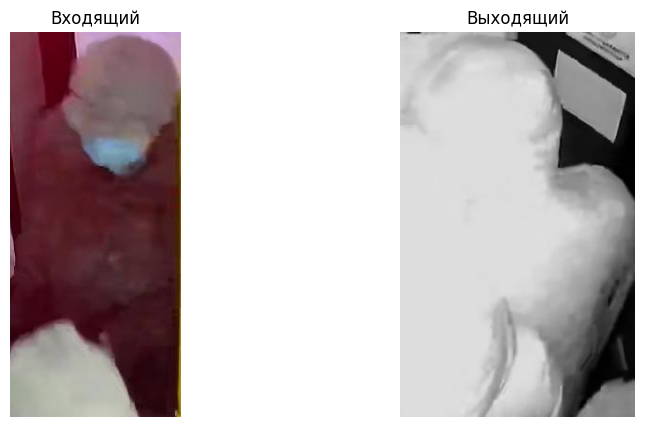

In [6]:
# Установка seed для воспроизводимости
random.seed(1)

# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))
    print(Image.open(img_path).size)


    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [5]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [6]:
x_org = []
y_org = []
# Задание высоты и ширины загружаемых изображений
img_height = 200
img_width = 200
j = 0
for i in data_files:
  x_org.append(image.img_to_array(image.load_img(i, target_size=(img_height, img_width))))
  y_org.append(data_labels[j])
  j+=1

In [7]:
del data_files
del data_labels

In [8]:
# Преобразование в numpy-массив загруженных изображений и меток классов
x_org_t = np.array(x_org)
y_org_t = np.array(y_org)
# Вывод размерностей
print('Размер массива x_train', x_org_t.shape)
print('Размер массива x_train', y_org_t.shape)

Размер массива x_train (9081, 200, 200, 3)
Размер массива x_train (9081,)


In [9]:
del x_org
del y_org

In [10]:
# Разделение данных на обучающий и тестовый наборы (80% обучающие, 20% тестовые)
x_train, x_test, y_train, y_test = train_test_split(x_org_t, y_org_t, test_size=0.2, random_state=42)

# Вывод размеров обучающего и тестового наборов
print("Размер обучающего набора:", len(x_train))
print("Размер тестового набора:", len(x_test))

Размер обучающего набора: 7264
Размер тестового набора: 1817


In [11]:
del x_org_t
del y_org_t

In [14]:
print(x_train.shape)
print(y_train.shape)
print()
print(x_test.shape)
print(y_test.shape)

(7264, 200, 200, 3)
(7264,)

(1817, 200, 200, 3)
(1817,)


In [12]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Проверка результата
print(f'Форма обучающих данных: {x_train.shape}')
print(f'Форма  тестовых данных: {x_test.shape}')

Форма обучающих данных: (7264, 120000)
Форма  тестовых данных: (1817, 120000)


In [18]:
print(f'Форма обучающих данных: {y_train.shape}')
print(f'Форма  тестовых данных: {y_test.shape}')

Форма обучающих данных: (7264,)
Форма  тестовых данных: (1817,)


In [13]:
# Нормализация входных картинок
# Преобразование x_train в тип float32 (числа с плавающей точкой) и нормализация
x_train = x_train.astype('float32') / 255.

# Преобразование x_test в тип float32 (числа с плавающей точкой) и нормализация
x_test = x_test.astype('float32') / 255.

In [14]:
gc.collect()

75

In [15]:
# Создание модели
model = Sequential()

# Добавление слоев
model.add(Dense(100, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [17]:
gc.collect()

233

In [18]:
# Обучение модели
history = model.fit(x_train,       # Обучающая выборка параметров
          y_train,       # Обучающая выборка меток класса
          batch_size=132,  # Размер батча (пакета)
          epochs=30,    # Количество эпох обучения
          validation_split=0.2,  # Доля проверочной выборки
          verbose=1)     # Отображение хода обучения

Epoch 1/30
45/45 [==============================] - 8s 120ms/step - loss: 7.3909 - accuracy: 0.6322 - val_loss: 3.0640 - val_accuracy: 0.4226
Epoch 2/30
45/45 [==============================] - 3s 60ms/step - loss: 1.4940 - accuracy: 0.7088 - val_loss: 0.5264 - val_accuracy: 0.7564
Epoch 3/30
45/45 [==============================] - 3s 72ms/step - loss: 1.2783 - accuracy: 0.6914 - val_loss: 3.2465 - val_accuracy: 0.7047
Epoch 4/30
45/45 [==============================] - 3s 59ms/step - loss: 0.8341 - accuracy: 0.7582 - val_loss: 1.8174 - val_accuracy: 0.7096
Epoch 5/30
45/45 [==============================] - 3s 77ms/step - loss: 1.3954 - accuracy: 0.6994 - val_loss: 0.9613 - val_accuracy: 0.7866
Epoch 6/30
45/45 [==============================] - 3s 59ms/step - loss: 0.7633 - accuracy: 0.7580 - val_loss: 1.4653 - val_accuracy: 0.7330
Epoch 7/30
45/45 [==============================] - 3s 59ms/step - loss: 0.5883 - accuracy: 0.7858 - val_loss: 0.6087 - val_accuracy: 0.7825
Epoch 8/30
4

In [23]:
gc.collect()

4060

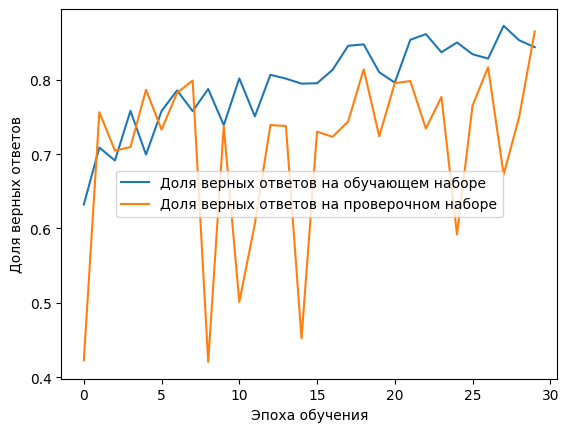

In [20]:
# Визуализация точности на обучающей выборке

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()

In [ ]:
gc.collect()

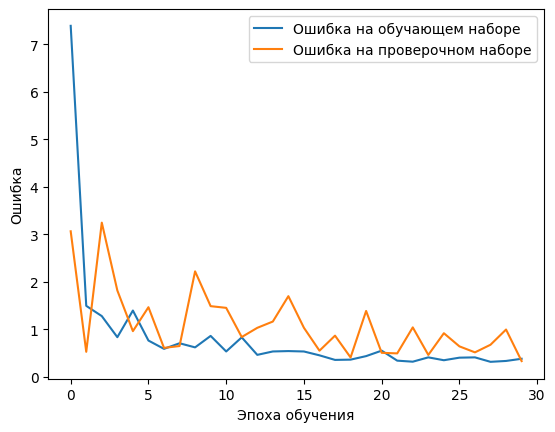

In [22]:
# Вывод графика ошибки
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
gc.collect()

In [24]:
scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print('Доля верных ответов на тестовых данных, в процентах: {:7.4%}'.format(scores[1]))

57/57 [==============================] - 1s 10ms/step - loss: 0.3443 - accuracy: 0.8509
[0.344345360994339, 0.8508530259132385]
Доля верных ответов на тестовых данных, в процентах: 85.0853%
